In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from typing import Union, Literal

## (a) Implement the 90-degree rotation group (cyclic group) over a plane including: 
    (i) group element
    (ii) group product (__mul__)
    (iii) group inverse (__invert__)
    (iv) group action (__call__)

In [3]:
class RotationGroupElement():
    """
    Implementation of the cyclic rotation group via implemention of a group element.
    """
    def __init__(self, idx: int) -> None:
        """
        Parameters:
            idx: Index of group element. 
                 Corresponds with number of 90 degree rotations performed.
        """
        assert(idx in [0,1,2,3])
        self.idx = idx

    def __call__(self, img: torch.tensor) -> torch.tensor:
        """
        Group action. Rotates img by (idx * 90) degrees.

        Note: rotates last two dimensions by default so that we can apply the
              group action to any kernel/signal of shape (..., H,W) or (..., W,H)
        """
        return torch.rot90(img, k=self.idx, dims=[-1,-2])

    def __mul__(self, other):
        """
        Group product: (g * g')(x) = g(g'(x))
        """
        new_idx = (self.idx + other.idx) % 4
        return RotationGroupElement(new_idx)

    def __invert__(self):
        """
        Group inverse: (~g * g) = identity
        """
        new_idx = (4 - self.idx) % 4
        return RotationGroupElement(new_idx)

## Apply the group actions on an image and print (imshow) them.

In [4]:
def plot_img(img_tensor):
    plt.imshow(img_tensor.squeeze(), cmap='gray')
    plt.show()

In [51]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]) )
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]) )

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

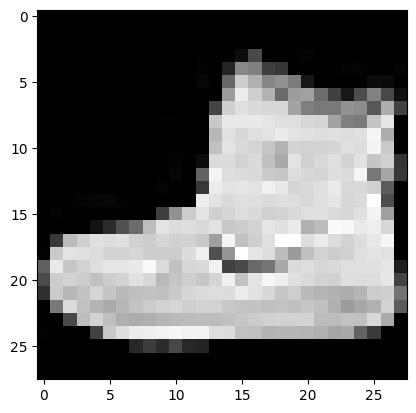

In [6]:
img = train_dataset[0][0]
plot_img(img)

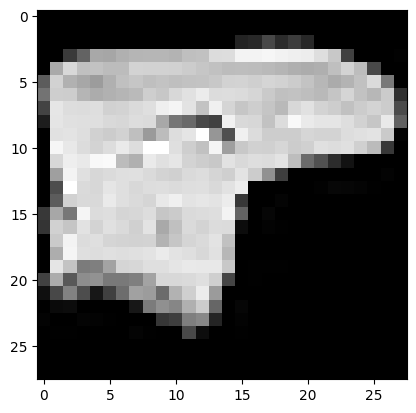

In [7]:
g = RotationGroupElement(2) # 180 degree rotation
plot_img(g(img))

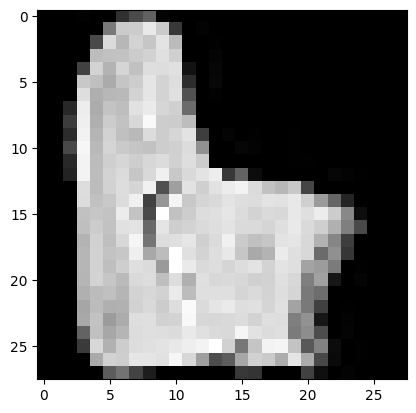

In [8]:
g = RotationGroupElement(1) # 90 degree rotation clockwise
plot_img(g(img))

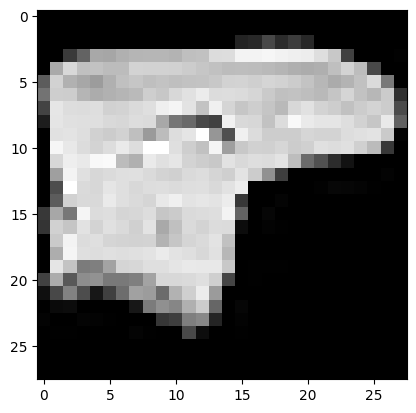

In [9]:
plot_img((g*g)(img)) # group product (composition) -> 180 degrees

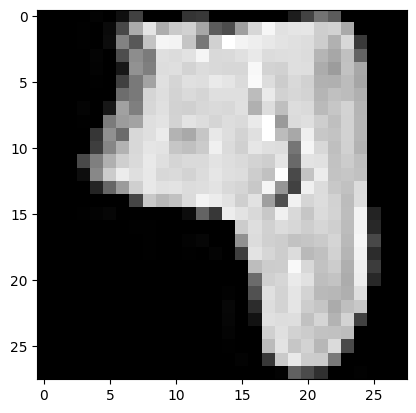

In [10]:
plot_img((~g)(img)) # inverse -> rotate 90 degrees counterclockwise

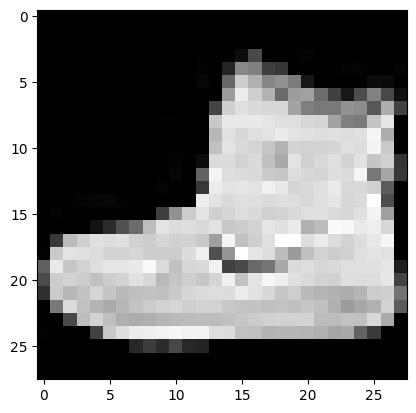

In [11]:
plot_img((~g*g)(img)) # inverse times original -> identity

## (b) Implement the lifting convolution, including: 
    (i) lifting kernel with: 
        input parameters size of the kernel
        input and output channel
        etc.
    (ii) forward function.

In [12]:
from torch import nn, optim
from torch import Tensor
import torch.nn.functional as F

In [13]:
class LiftingConv(nn.Module):
    def __init__(self,         
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: float = 1
        ):
        """
        input shape:
            (N, Ci, Hi, Wi )
            N = batch size
            Ci = input channels
            Hi = input height
            Wi = input Width

        output shape:
            (N, Co, G, Ho, Wo )
            N = batch size
            Co = output channels
            G = group order
            Ho = output height
            Wo = output Width
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = torch.nn.Parameter(torch.randn((out_channels, in_channels, kernel_size, kernel_size)) )


    def forward(self, input: Tensor):
        
        # convolve kernel with input under all group transformations:
        output = []
        for g in [RotationGroupElement(i) for i in [0,1,2,3]]:
            output.append(
                F.conv2d(input=input, 
                         weight=g(self.weight), 
                         stride=self.stride, 
                         padding=self.padding))

        output = torch.stack(output)

        # reshape:
        # (group_order, batch_size, out_channels, H, W) -> 
        # (batch_size, out_channels, group_order, H, W)        
        output = output.permute(1,2,0,3,4) 

        return output

## Applying the lifting convolution using a sobel filter to visualize the filter rotations:

In [14]:
lc = LiftingConv(1, 1, 3, 1, 1)
lc.weight = torch.nn.Parameter(torch.tensor(
    [[[[1,2,1],
       [0,0,0],
       [-1,-2,-1]
    ]]], dtype=torch.float32
))

In [15]:
x,y = next(iter(train_loader))

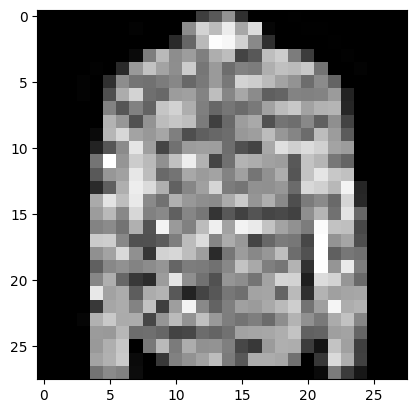

In [16]:
plot_img(x[0,0,:,:])

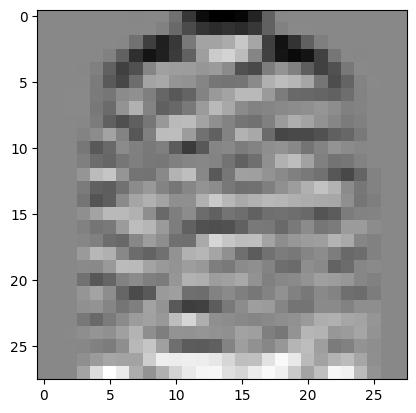

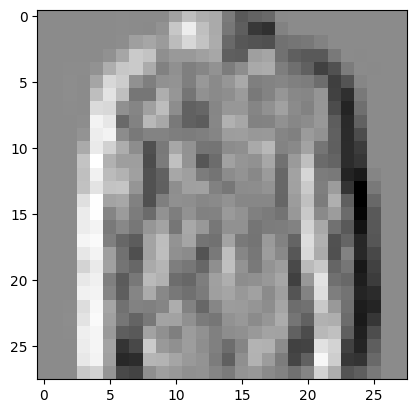

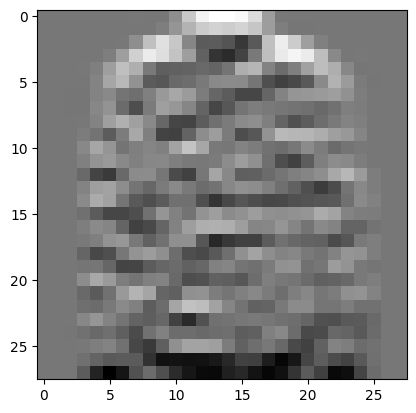

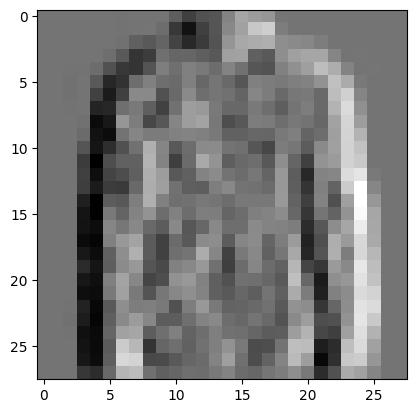

In [17]:
plot_img(lc(x)[0,0,0,:,:].detach())
plot_img(lc(x)[0,0,1,:,:].detach())
plot_img(lc(x)[0,0,2,:,:].detach())
plot_img(lc(x)[0,0,3,:,:].detach())

## (c) Implement the group convolution, including: 
    (i) group convolution kernel (with input parameters size of the kernel, input and output channel, etc. )
    (ii) the transformation of the group action
    (iii) bilinear interpolation (sampling)
    (iv) forward function.
    (Note that other weight initializations and interpolations are welcome to test/include.)


In [18]:
class GroupConv(nn.Module):
    def __init__(self,         
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: float = 1,
        group_order: int = 4
        ):
        """
        input shape:
            (N, Ci, Hi, Wi )
            N = batch size
            Ci = input channels
            G = group_order
            Hi = input height
            Wi = input Width

        output shape:
            (N, Co, G, Ho, Wo )
            N = batch size
            Co = output channels
            G = group order
            Ho = output height
            Wo = output Width
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = torch.nn.Parameter(torch.randn((out_channels, in_channels * group_order, kernel_size, kernel_size)) )


    def forward(self, input: Tensor):
        # swap axes so all channels of the same group index appear consecutively
        # this allows easy shifting of the convolved filter
        # (batch_size, in_channels, group_order, H, W) -> 
        # (batch_size, group_order, in_channels, H, W)
        input = input.swapaxes(1,2) 

        # reshape input:
        batch_size, group_order, in_channels, H, W = input.shape
        flattened_input = input.reshape(batch_size, in_channels * group_order, H, W)

        # convolve kernel
        output = []
        for i, g in [(i,RotationGroupElement(i)) for i in [0,1,2,3]]:
            output.append(
                F.conv2d(input=flattened_input, 
                         weight=torch.roll(g(self.weight), shifts=i*in_channels, dims=1), 
                         stride=self.stride, 
                         padding=self.padding))

        output = torch.stack(output)

        # (group_order, batch_size, out_channels, H, W) -> 
        # (batch_size, out_channels, group_order, H, W)        
        output = output.permute(1,2,0,3,4) 

        # return output
        return output

In [25]:
lc_out_channels = 8
gc_in_channels = lc_out_channels

lc = LiftingConv(1, 8, 3, 1, 1)
lc(x).shape

torch.Size([128, 8, 4, 28, 28])

In [26]:
gc = GroupConv(in_channels=gc_in_channels, out_channels=13)
gc.forward(lc(x)).shape

torch.Size([128, 13, 4, 28, 28])

## Lifting Convolution is Rotation Equivariant

In [27]:
g = RotationGroupElement(1)

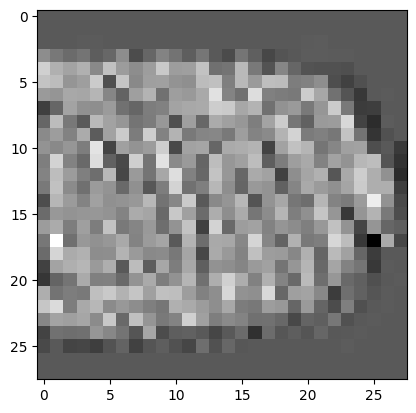

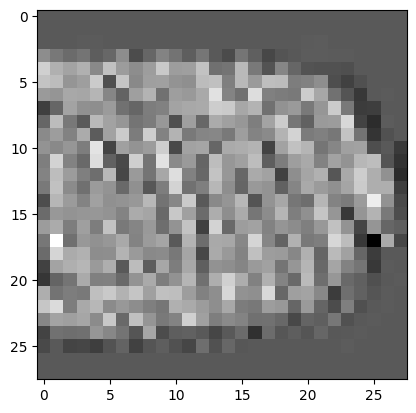

In [28]:
img1 = lc(g(x)).detach() # apply filter to rotated image
img2 = torch.roll(g(lc(x)).detach(), shifts=1, dims=2) # apply filter to original image, and rotate output (i.e rotate and shift by 1)    


random_idx = np.random.choice([0,1,2,3])
plot_img(img1[0,0,random_idx,:,:])
plot_img(img2[0,0,random_idx,:,:])

# Group Convolution is rotation equivariant:

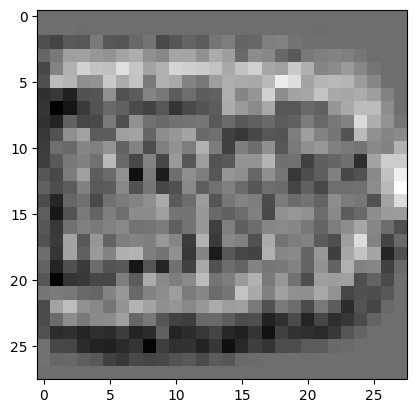

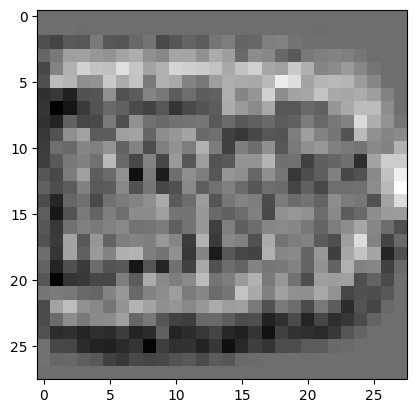

In [30]:
img1 = gc(lc(g(x))).detach() # apply filter to rotated image
img2 = torch.roll(g(gc(lc(x))).detach(), shifts=1, dims=2) # apply filter to original image, and rotate output (i.e rotate and shift by 1)

random_idx = np.random.choice([0,1,2,3])
plot_img(img1[0,0,random_idx,:,:])
plot_img(img2[0,0,random_idx,:,:])

## (d) Implement a group convolution neural net
    With:
        1. lifting convolution
        2. group convolution
        3. projection operation (using average-pooling or max-pooling over the group and spatial domain) 
    
    input parameters: 
        1. size of the kernel
        2. input and output channel
        3. the number of hidden layers
        4. the hidden channel, etc.

## (e) Experiment on the Fashion-MNIST dataset [1].
    
    i. Splittingthedatasetintotrainingandtestingsets(usetorchvision.datasets.FashionMNIST) with a batch size of 128. For testing sets, apply a random rotation of the degree
[0, 90, 180, 270] over the images.
Print a few examples from the testing set.
    
    ii. Train the group convolution neural net with the following hyperparameters: input channel = 1, output channel = 10, kernel size = 3, hidden layer number = 5,
hidden channel number = 16. For the optimizer, using Adam with the learning rate 10−2 and the weight decay 10−5.
    
    iii. Report the classification accuracy and print the obtained features after each operation (lifting convolution, group convolution, and projection). Show that the final represen- tations are indeed equivariant to 90-degree rotations.

    iv. Repeat steps (i)-(iii) but this time applying a random rotation [0, 2π] over the testing images. Compare the results and analyze how to improve the model for a random ro- tation [0, 2π].


In [67]:
from functools import partial

class GroupConvNet(nn.Module):
    def __init__(
            self,
            in_channels: int = 1,
            hidden_channels: int = 15,
            out_channels: int = 10, # number of classes
            kernel_size: int = 3,
            n_hidden_layers: int = 5,
            pooling_op: Union[Literal['avg'], Literal['max']] = 'avg'
    ) -> None:
        super().__init__()

        # lifting convolution:
        self.lc = LiftingConv(in_channels, hidden_channels, kernel_size, 1, 1)

        # group convolutions:
        self.gcs = torch.nn.ModuleList()
        for _ in range(n_hidden_layers):
            self.gcs.append(GroupConv(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2
            ))
        
        self.fc = nn.Linear(hidden_channels, out_channels)

        if pooling_op == 'avg':
            self.pool = partial(torch.mean, dim=(-3, -2, -1))
        elif pooling_op == 'max':
            self.pool = partial(torch.max, dim=(-3, -2, -1))
        else:
            raise ValueError(f'Pooling operation {pooling_op} not supported')


    def forward(self, x):

        x = self.lc(x)
        x = F.layer_norm(x, x.shape[-3:])
        x = F.relu(x)

        for gc in self.gcs:
            x = gc(x)
            x = F.layer_norm(x, x.shape[-3:])
            x = F.relu(x)

        x = self.pool(x)
        x = self.fc(x)
        
        return x


In [73]:
import lightning.pytorch as pl

class LitGroupConvNet(pl.LightningModule):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.net(x)
        
        loss = F.cross_entropy(y_hat, y)
        acc = torch.mean(y_hat.argmax(axis=1) == y, dtype=float)

        self.log_dict({
            "train_loss": loss,
            "accuracy": acc})
        
        return loss

    def configure_optimizers(self):
        # optimizer = optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-5)
        optimizer = optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-1)
        return optimizer


net = GroupConvNet(hidden_channels=100)
pl_model = LitGroupConvNet(net)

In [1]:
from torch import utils
from lightning.pytorch.loggers import TensorBoardLogger

if True:
    logger = TensorBoardLogger(
        "tb_logs", 
        name="my_model",
    )

    trainer = pl.Trainer(
        max_epochs=1000, 
        accelerator='cpu', 
        logger=logger,
        log_every_n_steps=1,
        overfit_batches=1
    )

    trainer.fit(
        model=pl_model, 
        train_dataloaders=train_loader
    )